# Detection of Pneumonia through Image classification

## Problem statement: Perform image classification of Chest Xray images to detect Pneumonia

## Importing the Packages

In [ ]:
%pip install scikit-learn==0.22.1
%pip install scipy==1.5.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Batch Processing the Images

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf


batch_size=8
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,vertical_flip=True, 
      horizontal_flip=True,
      rotation_range=0.4)
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

In [3]:
train_generator = train_datagen.flow_from_directory(
        '/mnt/batch/tasks/shared/LS_root/mounts/clusters/chestxray-compute/code/Users/navyasreesiri999/ChestXRay/chest_xray/train',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        classes = ['NORMAL', 'PNEUMONIA'],
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        '/mnt/batch/tasks/shared/LS_root/mounts/clusters/chestxray-compute/code/Users/navyasreesiri999/ChestXRay/chest_xray/test',
        target_size=(128, 128),
        batch_size=batch_size,
        #color_mode='grayscale',
        classes = ['NORMAL', 'PNEUMONIA'],
        class_mode='categorical')

train_label = train_generator.class_indices.keys()
print(train_label)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
dict_keys(['NORMAL', 'PNEUMONIA'])


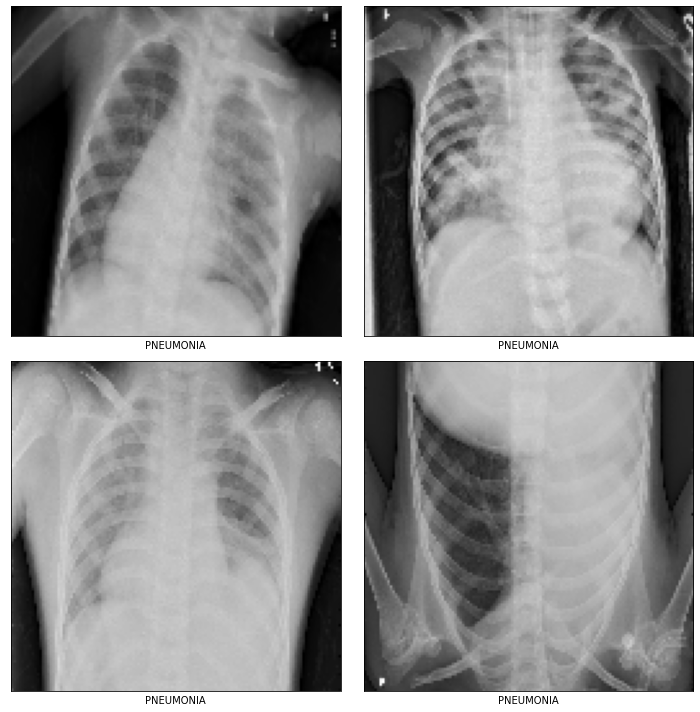

In [4]:
x,y = train_generator.next()

keys = train_generator.class_indices.keys()

# now let's show some randomly chosen images from the training set.
plt.figure(figsize=(10, 10))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image = x[i]
  label = y[i]
  index = np.argmax(label)
  plt.imshow(image, cmap = plt.cm.binary)
  plt.xlabel(list(keys)[index])

plt.tight_layout()
plt.show()

## Building the model

In [5]:
import tensorflow as tf
n_classes=train_generator.num_classes
def create_tf_model():
    model = tf.keras.models.Sequential(
[
tf.keras.layers.Conv2D(filters=10, kernel_size=5, input_shape=(128,128,3), activation='relu'),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),
tf.keras.layers.Conv2D(filters=20, kernel_size=5, activation='relu'),
tf.keras.layers.Dropout(rate=0.3),
tf.keras.layers.MaxPool2D(pool_size=(2,2)),

tf.keras.layers.Flatten(),
tf.keras.layers.Dense(320, activation='relu'),
tf.keras.layers.Dense(50, activation='relu'),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(n_classes, activation='softmax')
]
)
    return model

model = create_tf_model()
model.build()

2022-07-02 19:04:26.155914: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-07-02 19:04:26.323057: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-02 19:04:26.323115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (chestxray-compute): /proc/driver/nvidia/version does not exist
2022-07-02 19:04:26.325112: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-07-02 19:04:26.331948: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2593905000 Hz
2022-07-02 19:04:26.332828: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff05c000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 10)      760       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 20)        5020      
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 20)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 20)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16820)             0         
_________________________________________________________________
dense (Dense)                (None, 320)               5

In [7]:
## Taking Adam as our model optimizer since it implements gradient descent algorithm
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

## Model and experiment creation, workspace connection, and ML flow configuration to track metrics

In [8]:
from azureml.core import Workspace, Experiment
import mlflow, mlflow.tensorflow

ws = Workspace.from_config()

experiment = Experiment(ws, "chestxray-image-training")

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.start_run(experiment_id=experiment.id)
mlflow.tensorflow.autolog()

2022/07/02 19:08:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


## Training the model

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
tf.random.set_seed(101)
batch_size=32
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)

model.fit(train_generator, 
          validation_data=test_generator,
          callbacks=[es],
          epochs=3)

mlflow.end_run()

2022-07-02 19:08:29.453207: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-07-02 19:08:33.249238: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session started.
2022-07-02 19:08:33.859847: I tensorflow/core/profiler/rpc/client/save_profile.cc:168] Creating directory: /tmp/tmpytjae_yj/train/plugins/profile/2022_07_02_19_08_33
2022-07-02 19:08:33.860496: I tensorflow/core/profiler/rpc/client/save_profile.cc:174] Dumped gzipped tool data for trace.json.gz to /tmp/tmpytjae_yj/train/plugins/profile/2022_07_02_19_08_33/chestxray-compute.trace.json.gz
2022-07-02 19:08:33.861062: I tensorflow/core/profiler/utils/event_span.cc:288] Generation of step-events took 0.02 ms

2022-07-02 19:08:33.862266: I tensorflow/python/profiler/internal/profiler_wrapper.cc:87] Creating directory: /tmp/tmpytjae_yj/train/plugins/profile/2022_07_02_19_08_33Dumped tool data for overview_page.pb to /tmp/tmpytjae_yj/train/plugins/profile/2022_07_02_19_08_33/ch

Epoch 1/3
654/654 [==============================] - 541s 828ms/step - loss: 0.2855 - accuracy: 0.8918 - val_loss: 0.4896 - val_accuracy: 0.8093
Epoch 2/3
654/654 [==============================] - 435s 665ms/step - loss: 0.1883 - accuracy: 0.9331 - val_loss: 0.6074 - val_accuracy: 0.7564
Epoch 3/3
654/654 [==============================] - 337s 515ms/step - loss: 0.1700 - accuracy: 0.9400 - val_loss: 0.5556 - val_accuracy: 0.8029


In [10]:
## Checking the workspace

ws

Workspace.create(name='chestxray_ws', subscription_id='1514e04b-42dc-4d81-ba0d-1d2d3436b5e5', resource_group='rg1')

## Saving the created model

In [11]:
from azureml.core.model import Model
model.save('chestxray-model-pneu.h5')
registered_model = Model.register(
workspace=ws,
model_name='chestxray-model',
model_path='chestxray-model-pneu.h5',
model_framework=Model.Framework.TENSORFLOW,
model_framework_version=tf.__version__)

Registering model chestxray-model


In [12]:
tf.__version__

'2.2.0'

## Make a customized environment in which to run your model

In [13]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")
myenv.add_conda_package("tensorflow")
myenv.add_tensorflow_pip_package(core_type='cpu', version='2.2.0')

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [14]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.8.12

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

  - tensorflow==2.2.0
- scikit-learn
- tensorflow
channels:
- anaconda
- conda-forge



## Create a Container service to contain your model

### Create deployment configuration

In [15]:
from azureml.core.webservice import AciWebservice, Webservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {"data": "chest_xray", "type": "classification"}, 
                                               description = 'Medical Image Classification for Pneumonia')


In [16]:
%%writefile score.py
import json
import numpy as np
import os
#import joblib
import tensorflow as tf

from azureml.core.model import Model




def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    #model_path = os.path.join(os.getenv("AZUREML_MODEL_DIR"), "chestxray-model.h5")
    
    model_path = Model.get_model_path('chestxray-model-pneu.h5')
    model = tf.keras.models.load_model(model_path)


def run(raw_data):
    data = np.array(json.loads(raw_data)['chest_xray'])
    print(np.shape(data))
    data = np.reshape(data, (1,128,128,3))
    y_hat = model.predict(data)
    print("Executed predictions...")
    result = json.dumps(y_hat.tolist())
    return {"result": result}

Writing score.py


In [17]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(
    execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "test"
                                                 )

/tmp/ipykernel_10849/3913936463.py:3: DeprecationWarning: ContainerImage class has been deprecated and will be removed in a future release. Please migrate to using Environments. https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-environments
  image_config = ContainerImage.image_configuration(


## Deploy the model for inference in real time

In [18]:
service_name = 'chestxray-classifier'
service = Webservice.deploy(deployment_config = aciconfig,
                                            image_config = image_config,
                                            model_paths = ['chestxray-model-pneu.h5'],
                                            name = service_name,
                                            workspace = ws)

service.wait_for_deployment(show_output = True)
print(service.state)

Registering model chestxray-model-pneu.h5
Creating image
Running..........................................................................................................................................................................................................................
Succeeded
Image creation operation finished for image chestxray-classifier:1, operation "Succeeded"
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-07-02 20:16:07+00:00 Generating deployment configuration.
2022-07-02 20:16:07+00:00 Submitting deployment to compute.
2022-07-02 20:16:10+00:00 Checking the status of deployment chestxray-classifier..
2022-07-02 20:20:19+00:00 Checking the status of inference endpoint chestxray-classifier.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [19]:
print(service.scoring_uri)

http://cae8c3f9-e557-49dc-ab87-6c92ddb79128.eastus.azurecontainer.io/score


## View Endpoint

When the model has been successfully deployed, go to Endpoints in the left-hand menu of Azure Machine Learning Studio to view the endpoint. You may view the endpoint's status (healthy or unhealthy), logs, and consumption (how applications can consume the model).

## Deleting the Endpoint

In [69]:
service.delete()